# Static Unconstrained Optimization with Neural Network

In this code I try to approximate the value function of an unconstrained optimization problem by means of First Order Conditions. The idea that motivates the use of neural network to solve an optimization problem of this kind is related to the fact that in many economics problem we are interested in the Value Function and/or the optimal solution of a problem as a function of one or more parameter. Instead of solving repeatedly the same problem for each parameter here I propose a code that is able to solve once for a particular subset of the parameter space.

I use a problem with a closed form solution and I compare the true solution vs the approximated one

In [1]:
# Import section
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
import time

In [2]:
# Problem parameters
α_min = -2.
α_max = -1.

β_min = -1.
β_max = 1.

n = 10

A = np.linspace(α_min, α_max, n)
B = np.linspace(β_min, β_max, n)

BATCH_SIZE = 128

In [3]:
def true_sol(α, β):
    return -β/(2*α)

## The problem

I want to solve the following problem:

$$
V(\alpha, \beta) = \max_{x} \left\{ \alpha\;x^2 + \beta\; x \right\}\\
$$

Provided that $\alpha < 0$ the function is globally concave therefore the optimal solution will be:
$$
x^*(\alpha, \beta) = -\frac{\beta}{2\alpha}
$$

Therefore the value function will be:
$$
V(\alpha, \beta) = -\frac{\beta}{2}\left(1 + \frac{\beta}{\alpha}\right)
$$

Suppose that you don't know the explicit solution and you want to approximate the parametrized solution $x^*(\alpha, \beta)$. We recognize that $x^* : A \times B \rightarrow \mathbb{R}$ and this is the function we parametrize with a Neural Network. 

More specifically, the code below construct the approximated solution $\hat{x}^*(\alpha, \beta ; \theta)$ where $\theta$ are parameters of the neural network. I use 3 hidden layer with 128 units. Activation functions are tanh and the last layer has a linear transformation.

In [4]:
# Convenient function to construct the neural network
def NN(nUnits = 128, nLayers = 3, act_fun = 'tanh', input_dim = 2, output_dim = 1, activation_out = 'linear', initGuess = 0):
    model = tf.keras.models.Sequential()
    
    # Add the input layer
    model.add(tf.keras.layers.Dense(nUnits, activation=act_fun, input_dim=input_dim))
    
    # Add the intermediate layers
    for layer in range(nLayers - 1):
        model.add(tf.keras.layers.Dense(nUnits, activation = act_fun))
    
    # Output layer
    model.add(tf.keras.layers.Dense(output_dim, activation=activation_out))
    return model

In [5]:
x_NN = NN()

def x(α, β):
    # Normalize the input vectors
    α = (α - α_min)/(α_max - α_min)*2.0 - 1.0
    β = (β - β_min)/(β_max - β_min)*2.0 - 1.0

    # Concatenate
    inp = tf.concat([α, β], axis=1)

    # Output the solution
    return x_NN(inp)

## Constructing an appropriate Loss Function

Since for the parameter space the problem is Concave, a sufficient condition for a maximum is that:
$$\frac{\partial f(x^*)}{\partial x} = 0$$

that is $$\frac{\partial f}{\partial x} = 2 \alpha \hat{x}^*(\alpha, \beta ; \theta) + \beta = 0$$

At this point we can construct a loss function based on that condition, that is:

$$\mathcal{L}(\alpha, \beta, \hat{x}^*; \theta) = || 2 \alpha \hat{x}^*(\alpha, \beta ; \theta) + \beta ||_2^2$$

And we know that this function at his minimum must be 0. Therefore the problem we want to solve with the neural network is:

$$
\min_{\theta} = \mathcal{L}(\alpha, \beta, \hat{x}^*; \theta)
$$ 

A sketch of the algorithm is the following:

1) Sample $(\alpha, \beta)$ from the parameter space
2) Guess a solution at $\hat{x}^*(\alpha, \beta ; \theta)$
3) Evaluate $\mathcal{L}(\alpha, \beta, \hat{x}^*; \theta)$
4) Do a Backward pass when minimizing the Loss Function
5) Repeat from 1. Stop when max. iter is reached or error is below a threshold

How long you train the network determines the quality of the solution

In [6]:
def loss_function(n):
    
    # Sample the parameter space from uniform distribution (Here I use a discretized grid)
    α = np.random.choice(A, BATCH_SIZE).reshape(-1,1)
    β = np.random.choice(B, BATCH_SIZE).reshape(-1,1)

    # Guess the solution
    x_star = x(α, β)

    # Evaluate and return the loss function
    loss = 2*α*x_star + β
    
    return tf.reduce_mean(tf.square(loss)) 

In [7]:
Θ = x_NN.trainable_variables
optimizer = Adam(learning_rate=0.003)

@tf.function
def training_step():
    with tf.GradientTape(persistent=True) as tape:
        # Compute the loss function
        L = loss_function(BATCH_SIZE)
        
    # Compute the gradient of the total loss function with respect to the network parameters    
    grad = tape.gradient(L, Θ)

    # Update parameters
    optimizer.apply_gradients(zip(grad, Θ))
    
    return L

In [8]:
def train(epochs):
    # To store the loss in order to plot
    total_losses = []
    
    # Take track of the starting time
    start = time.time()
    
    for i in range(0, epochs):
        loss = training_step()
        
        # Append the loss function
        total_losses.append(loss.numpy())
        
        # Take track of the time
        now = time.time()
        
        print(f"""
        time elapsed: {now - start}
        epoch : {i+1}
        loss : {loss}
        """)
    return total_losses

In [ ]:
total_err = train(50000)

# Plots

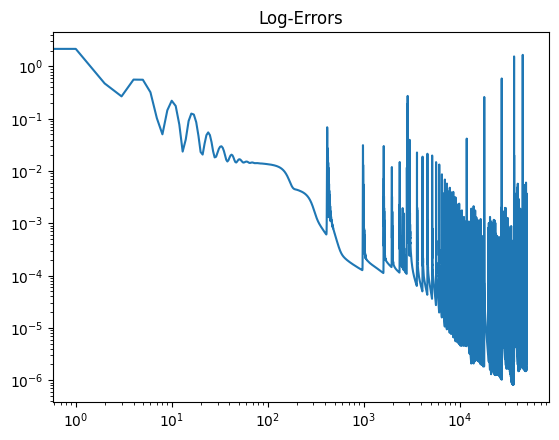

In [10]:
plt.figure()
plt.title('Log-Errors')
plt.xscale('log')
plt.yscale('log')
plt.plot(total_err)
plt.show()

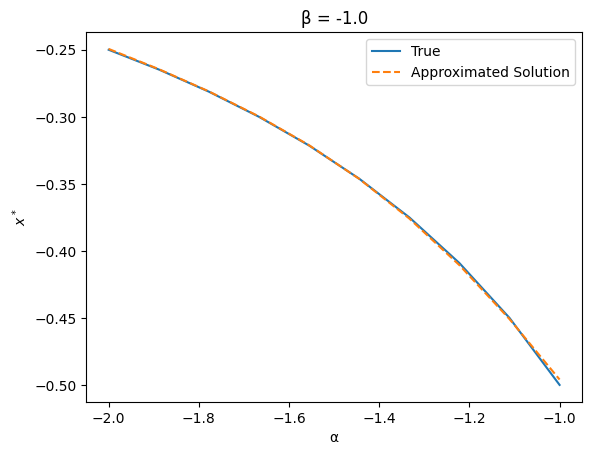

In [11]:
# Beta fixed
plt.figure()
b = np.linspace(β_min, β_min, n).reshape(-1,1)
plt.title(f"β = {β_min}")
plt.plot(A.reshape(-1,1), true_sol(A, β_min),label='True')
plt.plot(A.reshape(-1,1), x(A.reshape(-1,1), b),linestyle="--",label='Approximated Solution')
plt.xlabel("α")
plt.ylabel("$x^*$")
plt.legend()

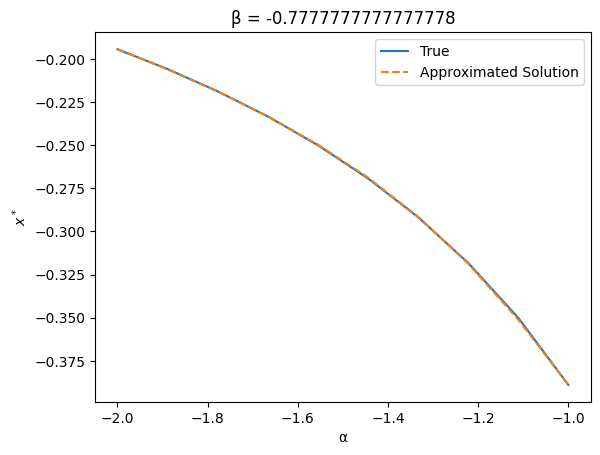

In [12]:
# Beta fixed
plt.figure()
b = np.linspace(B[1], B[1], n).reshape(-1,1)
plt.title(f"β = {B[1]}")
plt.plot(A.reshape(-1,1), true_sol(A, B[1]),label='True')
plt.plot(A.reshape(-1,1), x(A.reshape(-1,1), b),linestyle="--",label='Approximated Solution')
plt.xlabel("α")
plt.ylabel("$x^*$")
plt.legend()

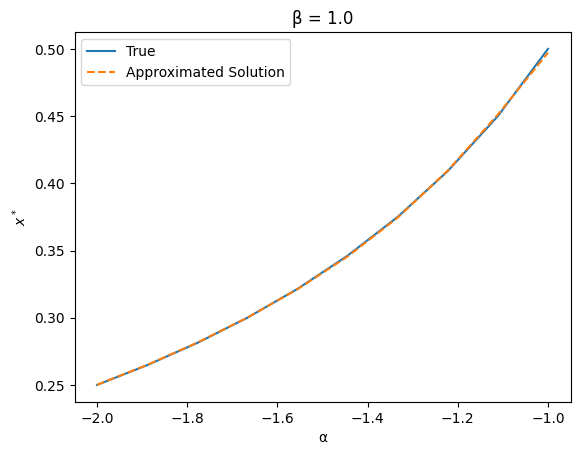

In [13]:
plt.figure()
b = np.linspace(B[9], B[9], n).reshape(-1,1)
plt.title(f"β = {B[9]}")
plt.plot(A.reshape(-1,1), true_sol(A, B[9]),label='True')
plt.plot(A.reshape(-1,1), x(A.reshape(-1,1), b),linestyle="--",label='Approximated Solution')
plt.xlabel("α")
plt.ylabel("$x^*$")
plt.legend()

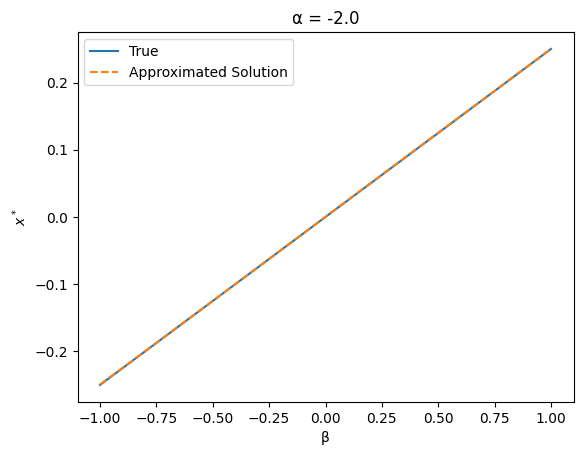

In [14]:
plt.figure()
b = np.linspace(A[0], A[0], n).reshape(-1,1)
plt.title(f"α = {A[0]}")
plt.plot(B.reshape(-1,1), true_sol(A[0], B),label='True')
plt.plot(B.reshape(-1,1), x(b, B.reshape(-1,1)),linestyle="--",label='Approximated Solution')
plt.xlabel("β")
plt.ylabel("$x^*$")
plt.legend()

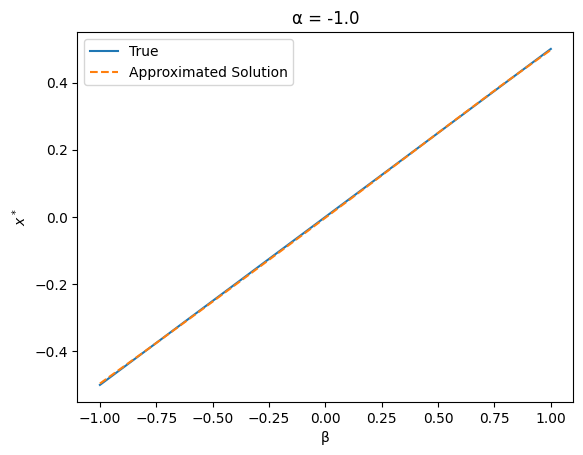

In [15]:
plt.figure()
b = np.linspace(A[9], A[9], n).reshape(-1,1)
plt.title(f"α = {A[9]}")
plt.plot(B.reshape(-1,1), true_sol(A[9], B),label='True')
plt.plot(B.reshape(-1,1), x(b, B.reshape(-1,1)),linestyle="--",label='Approximated Solution')
plt.xlabel("β")
plt.ylabel("$x^*$")
plt.legend()